In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import random

from sklearn.preprocessing import StandardScaler

# Data Generation

In [46]:
def data_generation(sigma):
  res = []
  for s in sigma:
    mean_pa = [-1, -1]
    cov_pa = np.array([[0.5, 0], [0, 1]]) * s

    mean_pb = [1, -1]
    cov_pb = np.array([[1, 0], [0, 2]]) * s

    mean_pc = [0, 1]
    cov_pc = np.array([[1, 0], [0, 2]]) * s

    num_points = 100
    num_clusters = 3

    dataset_pa = np.random.multivariate_normal(mean_pa, cov_pa, num_points)
    dataset_pb = np.random.multivariate_normal(mean_pb, cov_pb, num_points)
    dataset_pc = np.random.multivariate_normal(mean_pc, cov_pc, num_points)

    labels_pa = np.full(num_points, 0)
    labels_pb = np.full(num_points, 1)
    labels_pc = np.full(num_points, 2)

    data = np.vstack((dataset_pa, dataset_pb, dataset_pc))
    labels = np.hstack((labels_pa, labels_pb, labels_pc))

    # data = StandardScaler().fit_transform(data)
    res.append([data, labels])
  return res

res = data_generation([0.5, 1, 2, 4, 8])
# [0.5, 1, 2, 4, 8]

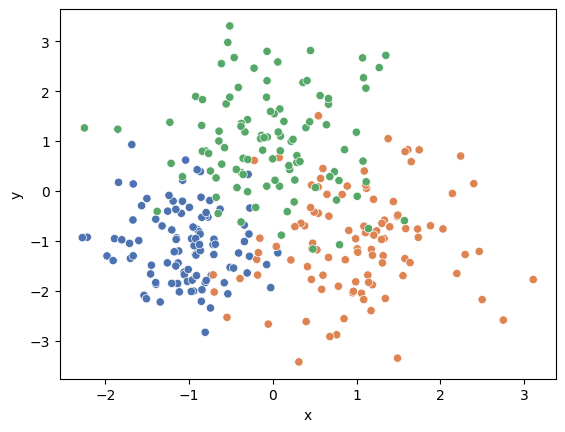

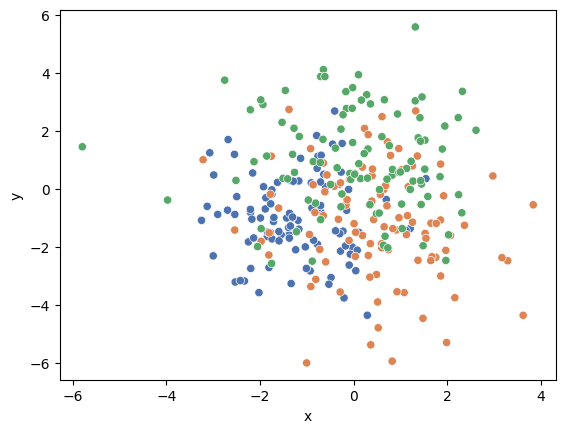

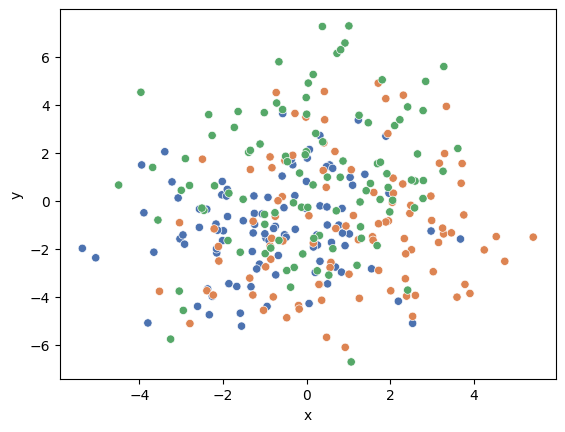

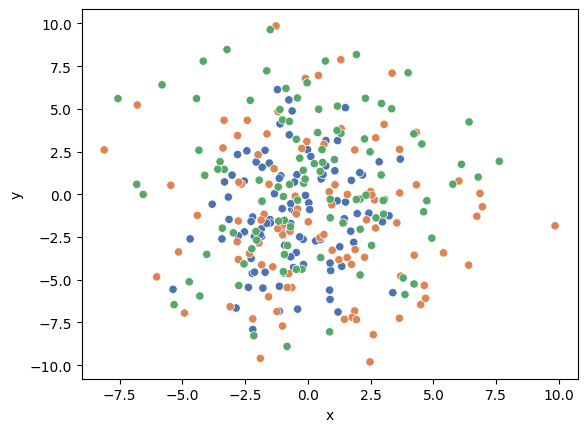

In [47]:
for item in res:
  data, labels = item
  sns.scatterplot(x=[X[0] for X in data],
                  y=[X[1] for X in data],
                  hue=labels,
                  palette="deep",
                  legend=None
                  )
  plt.xlabel("x")
  plt.ylabel("y")
  plt.show()

# K-Means Clustering

In [48]:
class KMeans:
  def __init__(self, clusters=3, max_iter=300):
    self.clusters = clusters
    self.max_iter = max_iter
    self.centroids = None

  def euclidean(self, point, data):
    return np.sqrt(np.sum((point - data)**2, axis=1))

  def fit(self, X_train):
    self.centroids = [random.choice(X_train)]

    for _ in range(self.clusters-1):
      dists = [self.euclidean(centroid, X_train) for centroid in self.centroids]
      dists = np.sum(dists, axis=0)
      dists /= np.sum(dists)
      new_centroid_idx = np.random.choice(range(len(X_train)), size=1, p=dists)[0]
      self.centroids += [X_train[new_centroid_idx]]

    counter = 0
    prev_centroids = None
    while np.not_equal(self.centroids, prev_centroids).any() and counter < self.max_iter:
      sorted_points = [[] for _ in range(self.clusters)]
      for x in X_train:
        dists = self.euclidean(x, self.centroids)
        centroid_idx = np.argmin(dists)
        sorted_points[centroid_idx].append(x)

      prev_centroids = self.centroids
      self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
      for i, centroid in enumerate(self.centroids):
        if np.isnan(centroid).any():
          self.centroids[i] = prev_centroids[i]
      counter += 1

  def evaluate(self, X):
    centroids = []
    centroid_idxs = []
    for x in X:
      dists = self.euclidean(x, self.centroids)
      centroid_idx = np.argmin(dists)
      centroid_idxs.append(centroid_idx)

    return np.array(centroid_idxs)[:, np.newaxis]

In [49]:
errors = []
accuracies = []
funcs = []
for item in res:
  data, labels = item
  kmeans = KMeans(clusters=3)
  kmeans.fit(data)
  funcs.append(kmeans)

for item, kmeans in zip(res, funcs):
  data, labels = item
  idxs = kmeans.evaluate(data)
  data = np.hstack((data, idxs))
  df = pd.DataFrame(data, columns=['x1', 'x2', 'labels'])
  df['x1'] = pd.to_numeric(df['x1'])
  df['x2'] = pd.to_numeric(df['x2'])
  # print(data)
  dist = 0
  for item in np.unique(idxs):
    temp = df[df['labels'] == item].iloc[:, :2].to_numpy()
    c = kmeans.centroids[item]
    dist += np.sum((c - temp)**2)
  print(dist)
  errors.append(dist)

  # centroid_ids = []
  # for item in [1, 2, 3]:
  #   cluster = data[labels == item].mean(axis=0)
  #   centroids = np.array(kmeans.centroids)
  #   print(cluster)
  #   print(centroids)
  #   dists = kmeans.euclidean(cluster, centroids)
  #   print(dists)
  #   break
  # Perform KMeans clustering

  # View results
  # sns.scatterplot(x=[X[0] for X in data],
  #                 y=[X[1] for X in data],
  #                 hue=labels,
  #                 palette="deep",
  #                 legend=None
  #                 )
  # plt.plot([x for x, _ in kmeans.centroids],
  #         [y for _, y in kmeans.centroids],
  #         '+',
  #         markersize=15,
  #         )
  # plt.title("k-means")
  # plt.show()

294.2276912102622
435.4953652458187
729.4990547896922
1345.0334530652094
2879.123529952936


In [50]:
for item, kmeans in zip(res, funcs):
  data, labels = item
  origmeans = []
  for i in range(3):
    temp = data[labels == i]
    origmeans.append(temp.mean(axis=0))
  idxs = kmeans.evaluate(data)
  centroids = kmeans.centroids
  origmeans = np.array(origmeans)
  cluster_map = {}
  for i, c in enumerate(centroids):
    temp = np.argmin(np.sqrt(np.sum((origmeans - c)**2, axis=1)))
    cluster_map[i] = temp

  mapped_function = np.vectorize(lambda x: cluster_map.get(x, x))
  mapped_array = mapped_function(idxs.flatten())
  print((mapped_array == labels).sum()*100/len(labels))
  accuracies.append((mapped_array == labels).sum()*100/len(labels))

85.33333333333333
74.33333333333333
63.666666666666664
52.0
44.0


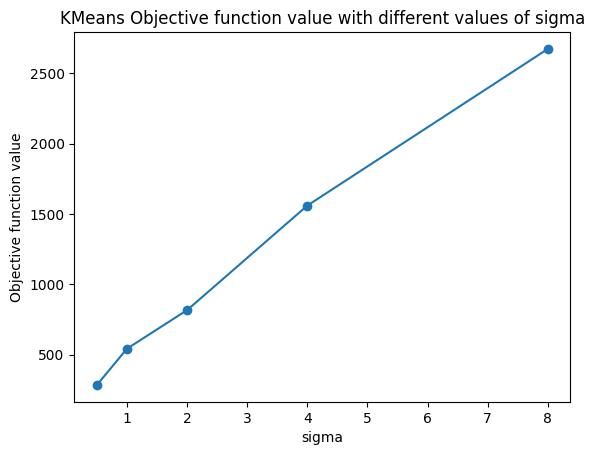

In [7]:
plt.plot([0.5, 1, 2, 4, 8], errors, marker='o')
plt.title("KMeans Objective function value with different values of sigma")
plt.xlabel("sigma")
plt.ylabel("Objective function value")
plt.show()

In [8]:
plt.plot([0.5, 1, 2, 4, 8], accuracies, marker='o')
plt.title("KMeans accuracy with different values of sigma")
plt.xlabel("sigma")
plt.ylabel("Accuracy")
plt.show()

# GMMS

In [51]:
import numpy as np
from scipy.stats import multivariate_normal

class gmm:
    def __init__(self, clusters, max_iterations=300):
        self.clusters = clusters
        self.max_iterations = max_iterations

    def euclidean(self, point, data):
      return np.sqrt(np.sum((point - data)**2, axis=1))

    def fit(self, X):
        n_samples, n_features = X.shape
        self.means = X[np.random.choice(n_samples, self.clusters, replace=False)]
        self.covariances = np.array([np.cov(X.T) for _ in range(self.clusters)])
        self.weights = np.ones(self.clusters) / self.clusters

        log_likelihoods = []
        for _ in range(self.max_iterations):
            responsibilities = self.calculate_responsibilities(X)

            Nk = responsibilities.sum(axis=0)
            self.means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
            cov = []
            for i in range(self.clusters):
              resp = responsibilities[:, i] * (X - self.means[i]).T
              means = X - self.means[i]
              currcov = np.dot(resp, means) / Nk[i]
              cov.append(currcov)
            self.covariances = np.array(cov)
            self.weights = Nk / len(X)

            log_likelihood = self.calculate_log_likelihood(X)
            log_likelihoods.append(log_likelihood)

        return self.means, self.covariances, log_likelihoods

    def calculate_responsibilities(self, X):
        responsibilities = np.zeros((len(X), self.clusters))
        for i in range(self.clusters):
            responsibilities[:, i] = self.weights[i] * multivariate_normal.pdf(X, self.means[i], self.covariances[i])
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities

    def calculate_log_likelihood(self, X):
        log_likelihood = np.zeros(X.shape[0])
        for i in range(self.clusters):
            log_likelihood += self.weights[i] * multivariate_normal.logpdf(X, self.means[i], self.covariances[i])
        return np.sum(log_likelihood)

    def evaluate(self, X, means):
      mean_idxs = []
      for x in X:
        dists = self.euclidean(x, means)
        mean_idx = np.argmin(dists)
        mean_idxs.append(mean_idx)
      return np.array(mean_idxs)[:, np.newaxis]

In [54]:
accuracies = []
errors = []
for item in res:
  data, labels = item
  origmeans = []
  for i in range(3):
    temp = data[labels == i]
    origmeans.append(temp.mean(axis=0))
  gmm_em = gmm(clusters=3)
  means, covariances, log_likelihoods = gmm_em.fit(data)
  idxs = gmm_em.evaluate(data, means)
  centroids = means
  origmeans = np.array(origmeans)
  cluster_map = {}
  for i, c in enumerate(centroids):
    temp = np.argmin(np.sqrt(np.sum((origmeans - c)**2, axis=1)))
    cluster_map[i] = temp

  mapped_function = np.vectorize(lambda x: cluster_map.get(x, x))
  mapped_array = mapped_function(idxs.flatten())
  print((mapped_array == labels).sum()*100/len(data))
  accuracies.append((mapped_array == labels).sum()*100/len(data))
  print(log_likelihoods[-1])
  errors.append(log_likelihoods[-1])

87.0
-1791.1352946240304
73.0
-1360.8423798708643
65.0
-1466.437976931773
51.666666666666664
-1703.3735873399414
47.333333333333336
-2760.2397449172186


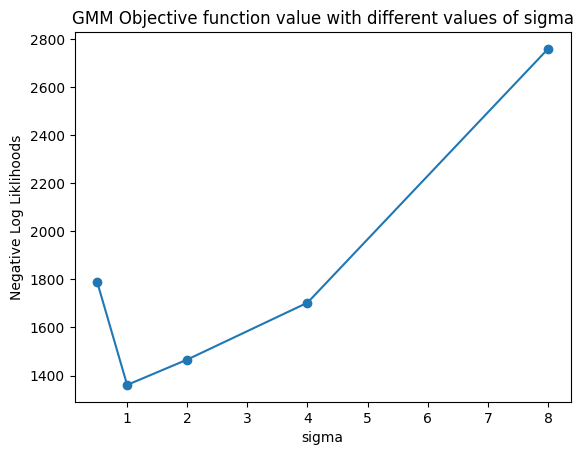

In [55]:
errors2 = [-x for x in errors]
plt.plot([0.5, 1, 2, 4, 8], errors2, marker='o')
plt.title("GMM Objective function value with different values of sigma")
plt.xlabel("sigma")
plt.ylabel("Negative Log Liklihoods")
plt.show()

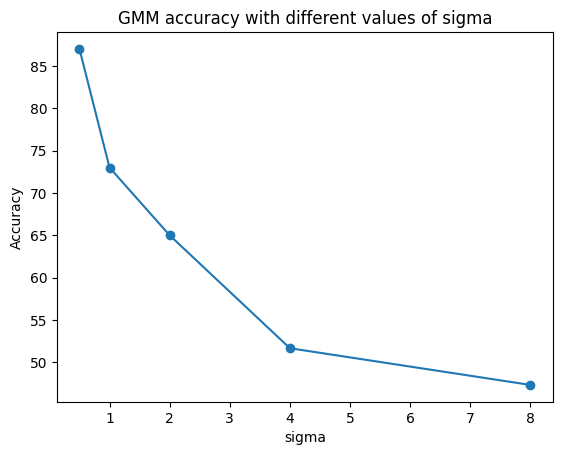

In [56]:
plt.plot([0.5, 1, 2, 4, 8], accuracies, marker='o')
plt.title("GMM accuracy with different values of sigma")
plt.xlabel("sigma")
plt.ylabel("Accuracy")
plt.show()

# PCA

In [21]:
%%capture
!unzip data.zip

In [58]:
def buggy_pca(X, d):
    U, Sigma, VT = np.linalg.svd(X, full_matrices=False)
    A = VT.T[:, :d]
    Z = np.dot(X, A)
    reconstructions = np.dot(Z, A.T)
    error = np.sum(np.square(X - reconstructions))
    return reconstructions, error, A, Z

def demeaned_pca(X, d):
    mean_X = np.mean(X, axis=0)
    centered_X = X - mean_X
    U, Sigma, VT = np.linalg.svd(centered_X, full_matrices=False)
    A = VT.T[:, :d]
    Z = np.dot(centered_X, A)
    reconstructions = np.dot(Z, A.T) + mean_X
    error = np.sum(np.square(X - reconstructions))
    return reconstructions, error, A, Z

def normalized_pca(X, d):
    mean_X = np.mean(X, axis=0)
    std_X = np.std(X, axis=0)
    normalized_X = (X - mean_X) / std_X
    U, Sigma, VT = np.linalg.svd(normalized_X, full_matrices=False)
    A = VT.T[:, :d]
    Z = np.dot(normalized_X, A)
    reconstructions = np.dot(Z, A.T) * std_X + mean_X
    error = np.sum(np.square(X - reconstructions))
    return reconstructions, error, A, Z

def dro(X, d):
    meanX = np.mean(X, axis=0)
    X -= meanX

    U, S, Vt = np.linalg.svd(X, full_matrices=False)

    Z = np.dot(U[:, :d], np.diag(S[:d]))

    A = Vt[:d, :].T

    b = meanX

    reconstructions = np.dot(Z, A.T) + b

    error = np.sum(np.square(X + meanX - reconstructions))
    return reconstructions, error, A, Z, b

def plot_original_vs_reconstructed(original_data, reconstructed_data, error, method):
    plt.scatter(original_data[:, 0], original_data[:, 1], c='b', marker='o', label='Original', alpha=0.7)
    plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c='r', marker='x', label='Reconstructed', alpha=0.7)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.title(f'Original vs Reconstructed Data for {method}\nReconstruction Error: {error:.4f}')
    plt.grid(True)
    plt.show()

In [59]:
twoD = np.loadtxt("data/data2D.csv", delimiter=",")

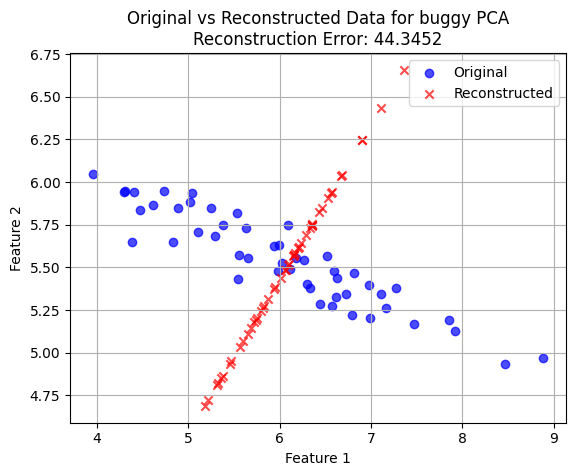

In [60]:
points, error, _, _ = buggy_pca(twoD.copy(), 1)
plot_original_vs_reconstructed(twoD, points, error, "buggy PCA")

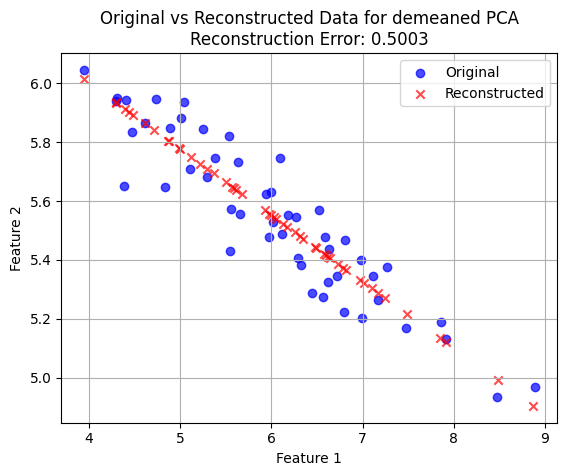

In [61]:
points, error, _, _ = demeaned_pca(twoD.copy(), 1)
plot_original_vs_reconstructed(twoD, points, error, "demeaned PCA")

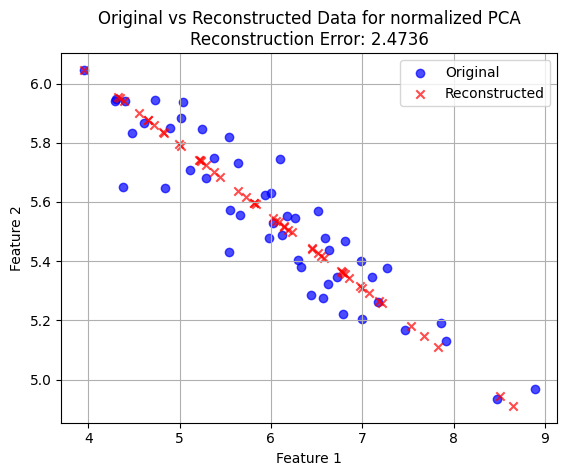

In [32]:
points, error, _, _ = normalized_pca(twoD.copy(), 1)
plot_original_vs_reconstructed(twoD, points, error, "normalized PCA")

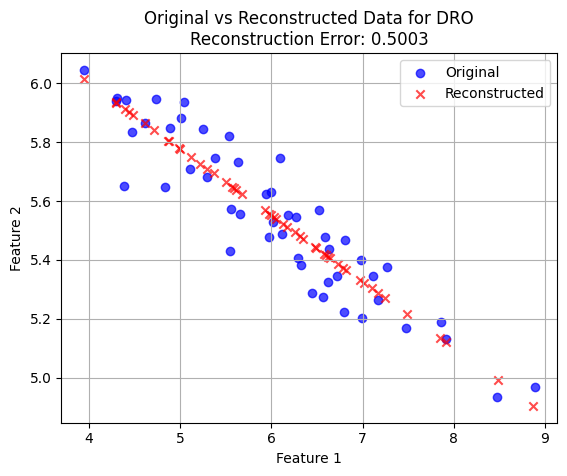

In [33]:
points, error, _, _, _ = dro(twoD.copy(), 1)
plot_original_vs_reconstructed(twoD, points, error, "DRO")

In [62]:
thousandD = np.loadtxt("data/data1000D.csv", delimiter=",")

In [63]:
tempX = thousandD
mean_X = np.mean(tempX, axis=0)
temp_X = tempX - mean_X
U, Sigma, VT = np.linalg.svd(temp_X, full_matrices=False)
print(temp_X.shape)
# powers = [Sigma[i][i] for i in range(len(Sigma))]

(500, 1000)


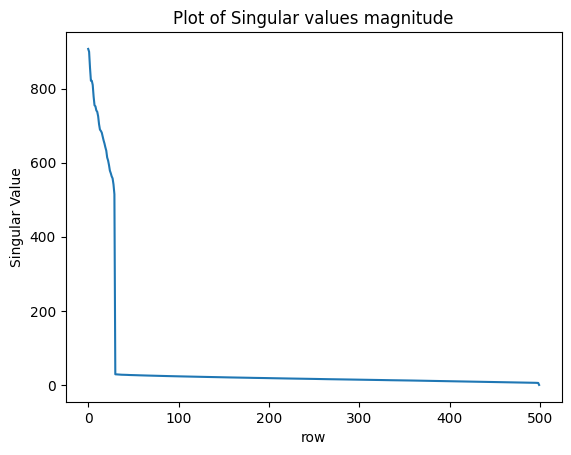

In [64]:
plt.plot(Sigma)
plt.xlabel("row")
plt.ylabel("Singular Value")
plt.title("Plot of Singular values magnitude")
plt.show()

In [65]:
points, error, _, _ = buggy_pca(thousandD, 30)
print(error)
points, error, _, _ = demeaned_pca(thousandD, 30)
print(error)
points, error, _, _ = normalized_pca(thousandD, 30)
print(error)
points, error, _, _, _ = dro(thousandD, 30)
print(error)

401365.69931017933
136522.9794893014
136814.2904988116
136522.9794893014
